In [ ]:
 !pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

# Carga de datos

In [ ]:
import pandas as pd
from datasets import load_dataset
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import defaultdict, Counter
from tqdm import tqdm
import spacy
from string import punctuation


In [ ]:
 # Cargar el dataset de IMDb
 dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
 # Convertir a DataFrame para una fácil manipulación
 train_df_total = pd.DataFrame(dataset['train'])
 test_df_total = pd.DataFrame(dataset['test'])

In [ ]:
#Sacar una muestra del dataset (30% en este caso)
train_df = train_df_total.sample(frac=0.3, random_state=42)
test_df = test_df_total.sample(frac=0.3, random_state=42)

In [ ]:
train_df.head()

,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1


# Procesamiento del texto

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de haber descargado los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Contar palabras antes de la tokenización
all_text = ' '.join(train_df['text']).lower()
all_words = word_tokenize(all_text)
word_count_before = len(all_words)

In [ ]:
train_df['tokenized_text'] = train_df['text'].apply(lambda x: word_tokenize(x.lower()))
# Contar palabras después de la tokenización
all_words_after_tokenization = [word for sublist in train_df['tokenized_text'] for word in sublist]
word_count_after = len(all_words_after_tokenization)

In [ ]:
# Ranking de las palabras más repetidas
word_freq = Counter(all_words_after_tokenization)
most_common_words = word_freq.most_common(10)

In [ ]:
# Mostrar resultados
print(f"Conteo de palabras antes de la tokenización: {word_count_before}")
print(f"Conteo de palabras después de la tokenización: {word_count_after}")
print("Ranking de las palabras más repetidas después de la tokenización:")
print(most_common_words)

Conteo de palabras antes de la tokenización: 2118905
Conteo de palabras después de la tokenización: 2119046
Ranking de las palabras más repetidas después de la tokenización:
[('the', 100666), (',', 82025), ('.', 70772), ('and', 49210), ('a', 48488), ('of', 43609), ('to', 40799), ('is', 33099), ('>', 30590), ('/', 30563)]


In [ ]:
# Función de preprocesamiento
def preprocess_text(df):
    # Tokenización
    df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x.lower()))
    # Eliminación de puntuaciones y stopwords
    stop_words = set(stopwords.words('english'))
    df['processed_text'] = df['tokenized_text'].apply(
        lambda x: [word for word in x if word.isalpha() and word not in stop_words]
    )
    # Lematización
    lemmatizer = WordNetLemmatizer()
    df['lemmatized_text'] = df['processed_text'].apply(
        lambda x: [lemmatizer.lemmatize(word) for word in x]
    )
    # Unir las palabras lematizadas de cada reseña en un solo string
    df['lemmatized_text_str'] = df['lemmatized_text'].apply(lambda x: ' '.join(x))
    return df

In [ ]:
# Preprocesar el texto en train_df y test_df
train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)

In [ ]:
# Contar palabras después de la lematización
all_words_after_lemmatization = [word for sublist in train_df['lemmatized_text'] for word in sublist]
word_count_after = len(all_words_after_lemmatization)

# Ranking de las palabras más repetidas después de la lematización
word_freq = Counter(all_words_after_lemmatization)
most_common_words = word_freq.most_common(10)

# Mostrar resultados
print(f"Conteo de palabras después de la lematización: {word_count_after}")
print("Ranking de las palabras más repetidas después de la lematización:")
print(most_common_words)

Conteo de palabras después de la lematización: 889744
Ranking de las palabras más repetidas después de la lematización:
[('br', 30492), ('movie', 15150), ('film', 13970), ('one', 7854), ('like', 6137), ('good', 4504), ('time', 4495), ('character', 4115), ('would', 4096), ('even', 3817)]


# Vectorización con TF-IDF

In [ ]:
# Vectorizar los datos de entrenamiento y prueba utilizando TF-IDF
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_df['lemmatized_text_str'])
X_test = tfidf_vectorizer.transform(test_df['lemmatized_text_str'])

y_train = train_df['label']
y_test = test_df['label']

# Modelo de Regresión Logística para estimar sentimiento

In [ ]:
# Entrenar el modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Predecir en el conjunto de prueba
y_pred = log_reg.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados de la evaluación
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8568
Precision: 0.85
Recall: 0.8663287086446104
F1 Score: 0.8580866807610994


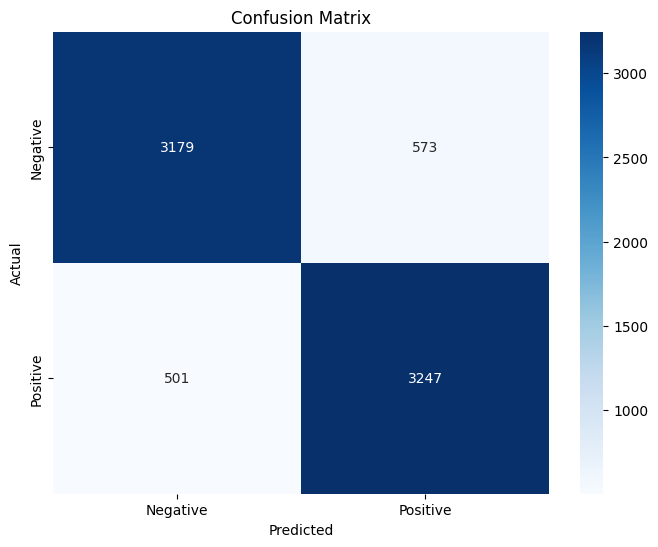

In [ ]:
# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**El modelo parece ser muy preciso. Tiene un accuracy del 85%, número recontra aceptable y viendo la matriz de confusión vemos que sufre de pocos falsos positivos y falsos negativos**

# Técnicas de mejora:

## WORD 2 VEC

Una posible mejora es vectorizar con el embedding WORD2VEC en vez de TF-IDF, ques es una herramienta mucho más potente y precisa porque logra captar mejor el sentido contextual de las palabras y de las oraciones
Word2vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Entrenamiento del modelo Word2Vec
word2vec_model = Word2Vec(sentences=train_df['tokenized_text'], vector_size=100, window=5, min_count=1, sg=1)

# Función para promediar vectores de palabras
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Construcción de los vectores de características para train_df y test_df
num_features = 100
vocabulary = set(word2vec_model.wv.index_to_key)

train_df['word2vec_features'] = train_df['tokenized_text'].apply(
    lambda x: average_word_vectors(x, word2vec_model, vocabulary, num_features)
)

test_df['word2vec_features'] = test_df['tokenized_text'].apply(
    lambda x: average_word_vectors(x, word2vec_model, vocabulary, num_features)
)

In [ ]:
# Preparación de los datos para el modelo de regresión logística
X_train = pd.DataFrame(train_df['word2vec_features'].tolist())
y_train = train_df['label']

X_test = pd.DataFrame(test_df['word2vec_features'].tolist())
y_test = test_df['label']

# Entrenamiento del modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Predicción en el conjunto de prueba
y_pred = log_reg.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados de la evaluación
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.81
Precision: 0.8065452626022698
Recall: 0.8153681963713981
F1 Score: 0.8109327318561763


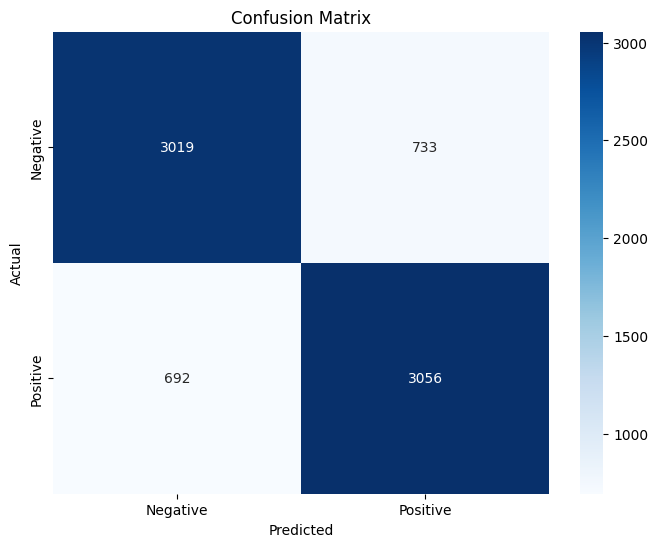

In [ ]:
# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

En este caso el resultado sorprendentemente fue peor, esto se puede deber a algunas razones:
- La función de word2vec requiere cierta optimización que no realizamos (vector size, window, método)
- Puede que el tamaño de las reseñas, al no ser muy largas, haga que word2vec no funcione de manera tan precisa.

## Otra forma de mejora es utilizar PYSENTIMIENTO para estimar el sentimiento del texto

Pysentimiento es un modelo preentrenado que se utiliza para analizar el sentimiento de frases. Es muy útil cuando no tenemos una referencia como en el ejemplo anterior y necesitamos categorizar algún texto entre sentimiento positivo y negativo. En este caso, sirve para ver si nuestro modelo es mejor o si nos conviene usar también en este caso Pysentimiento.

In [ ]:
pip install pysentimiento

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 29.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [ ]:
from pysentimiento import create_analyzer

In [ ]:
# Inicializar el analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="en")

In [ ]:
# @title Aplicarselo a todo el df tarda mucho tiempo y no me llegó a correr, pero lo dejo a modo demostrativo:

# Predecir sentimientos en el conjunto de prueba utilizando Pysentimiento
test_df['pysentimiento_pred'] = test_df['text'].apply(lambda x: analyzer.predict(x).output)
test_df['pysentimiento_pred'] = test_df['pysentimiento_pred'].map({'POS': 1, 'NEG': 0})

# Evaluar el modelo de Pysentimiento
accuracy_pysentimiento = accuracy_score(test_df['label'], test_df['pysentimiento_pred'])
precision_pysentimiento = precision_score(test_df['label'], test_df['pysentimiento_pred'])
recall_pysentimiento = recall_score(test_df['label'], test_df['pysentimiento_pred'])
f1_pysentimiento = f1_score(test_df['label'], test_df['pysentimiento_pred'])
conf_matrix_pysentimiento = confusion_matrix(test_df['label'], test_df['pysentimiento_pred'])

# Mostrar resultados de la evaluación
print(f"Accuracy (Pysentimiento): {accuracy_pysentimiento}")
print(f"Precision (Pysentimiento): {precision_pysentimiento}")
print(f"Recall (Pysentimiento): {recall_pysentimiento}")
print(f"F1 Score (Pysentimiento): {f1_pysentimiento}")

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pysentimiento, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Pysentimiento)')
plt.show()

In [ ]:
# Seleccionar aleatoriamente el 1% del DataFrame test_df
test_sample_df = test_df.sample(frac=0.01, random_state=42)

# Inicializar el analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="en")

# Predecir sentimientos en el subconjunto del 1% utilizando Pysentimiento
test_sample_df['pysentimiento_pred'] = test_sample_df['text'].apply(lambda x: analyzer.predict(x).output)
test_sample_df['pysentimiento_pred'] = test_sample_df['pysentimiento_pred'].map({'POS': 1, 'NEG': 0})

test_sample_df.dropna(subset=['pysentimiento_pred'], inplace=True)


# Evaluar el modelo de Pysentimiento
accuracy_pysentimiento = accuracy_score(test_sample_df['label'], test_sample_df['pysentimiento_pred'])
precision_pysentimiento = precision_score(test_sample_df['label'], test_sample_df['pysentimiento_pred'])
recall_pysentimiento = recall_score(test_sample_df['label'], test_sample_df['pysentimiento_pred'])
f1_pysentimiento = f1_score(test_sample_df['label'], test_sample_df['pysentimiento_pred'])
conf_matrix_pysentimiento = confusion_matrix(test_sample_df['label'], test_sample_df['pysentimiento_pred'])

# Mostrar resultados de la evaluación
print(f"Accuracy (Pysentimiento): {accuracy_pysentimiento}")
print(f"Precision (Pysentimiento): {precision_pysentimiento}")
print(f"Recall (Pysentimiento): {recall_pysentimiento}")
print(f"F1 Score (Pysentimiento): {f1_pysentimiento}")


Accuracy (Pysentimiento): 0.9166666666666666
Precision (Pysentimiento): 0.9333333333333333
Recall (Pysentimiento): 0.9032258064516129
F1 Score (Pysentimiento): 0.9180327868852459


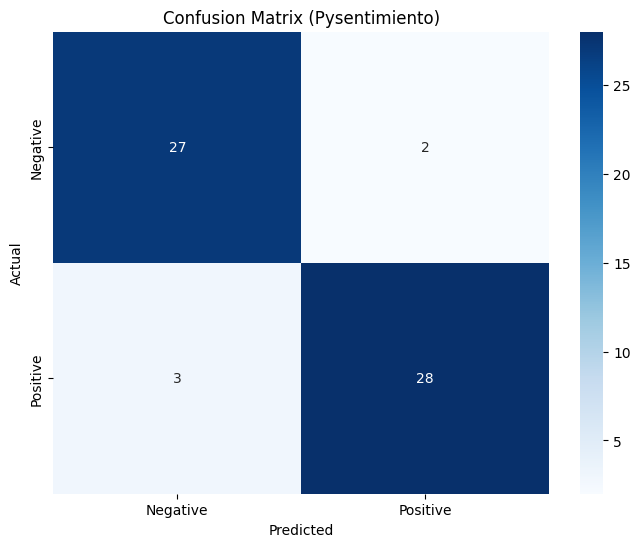

In [ ]:
# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pysentimiento, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Pysentimiento)')
plt.show()

La muestra es muuuuuy chiquita, pero aún así los resultados con pysentimiento fueron muy positivos.

# PARTE DE ALGORITMOS GENÉTICOS:

2.a) Partiendo del código original, yo cambiaría 2 cosas en la función de aptitud:
-Por un lado: No la haría lineal, sino que exponencial.
Cambiaría esto: *this.fitness = score / target.length*
Por esto: *this.fitness = score / target.length; this.fitness = pow(this.fitness, 4);*
Esto generará que al principio, cada avance no sea muy significativo, pero que al final, cuando se esté más cerca del resultado final, cada elemento con una pequeña mejora va a pasar a pesar mucho más que el resto, haciendo más probable que lo elijan para reproducirse. Sin embargo, no hay que pasarse de rosca con la exponencialidad porque si está elevado a un n muy alto el modelo se vuelve muy pesado y lento.


-Por otro lado, la agregaría una suma de 0.01 al fitness. Esto generaría que en el caso donde todos los elementos de la población inicial tengan 0 de fitness y estemos usando algun método para elegir a los padres como aceptar rechazar/método del dardo, no quede atrapado en un bucle infinito.

2.b) Para resolver un problema distinto, hay que cambiar el ADN y la función de aptitud, y adaptarlos al nuevo problema.

En el caso del código, el ADN es el siguiente:


**function newChar() {let c = floor(random(63, 122)); if (c === 63) c = 32; if (c === 64) c = 46; return String.fromCharCode(c);}// Constructor (makes a random DNA)class DNA {constructor(num) {// The genetic sequence this.genes = []; this.fitness = 0; for (let i = 0; i < num; i++) {this.genes[i] = newChar(); // Pick from range of chars}}**

Por un lado está la función newchar, que selecciona un caracter al azar y por otro lado está el constructor class DNA que es el que construye cada elemento de la población.






La función de aptitud del código es la siguiente. Acá se calcula el % de caracteres correctos dentro del elemento.

  **// Fitness function (returns floating point % of "correct" characters) calcFitness(target) {    let score = 0;    for (let i = 0; i < this.genes.length; i++) {      if (this.genes[i] == target.charAt(i)) {        score++;      }    }    this.fitness = score / target.length;    this.fitness = pow(this.fitness, 4);}**